# xSIT Models

In this notebook, we will consider examples of applying set-input models to an artificially generated regression dataset.

The main idea of artificial generation is as follows: each feature of the regression dataset example is mapped to a separate instance, and the group (bag) consists of all instances corresponding to the features.

Such an example allows, in addition to assessing the accuracy on regression problems (in general, without Multiple Instance Regression assumptions),
to consider an example of interpreting the Grad-SIT model.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
from sit.mil.data import MILData
from sit.dataset.gen import FeaturesAsInstancesDataGen

In [4]:
orig_X, orig_y = make_friedman1(n_samples=400, n_features=8, random_state=1234)

### Generate set-input dataset from classical regression one

In [5]:
mil_data = FeaturesAsInstancesDataGen(index_features='one_hot').make(orig_X, orig_y)

In [6]:
train_idx, test_idx = train_test_split(np.arange(len(mil_data)), test_size=0.5, random_state=12345)
mil_data_train, mil_data_test = mil_data[train_idx], mil_data[test_idx]

GBM performance on the original dataset (as a reference):

In [7]:
classical_model = GradientBoostingRegressor()
classical_model.fit(orig_X[train_idx], orig_y[train_idx])
print(
    'R2 train', r2_score(orig_y[train_idx], classical_model.predict(orig_X[train_idx])),
    'test', r2_score(orig_y[test_idx], classical_model.predict(orig_X[test_idx]))
)

R2 train 0.9941940669363512 test 0.8906410066457969


## Set-Input Models

In [8]:
from sit.tree.any_all import AnyAllSetInputTree  # Tree-PA
from sit.tree.fraction import FractionSetInputTree  # Tree-Frac
from sit.gradtree.grad_boosting import GradBoostingClassifier, GradBoostingRegressor
from sit.gradtree.regressor import GradSITRegressor, GradSetForestRegressor

In [9]:
def print_metrics(predict_fn, mil_data_train, mil_data_test):
    print(
        'R2 train', r2_score(mil_data_train.y, predict_fn(mil_data_train.X, mil_data_train.group_sizes)),
        'test', r2_score(mil_data_test.y, predict_fn(mil_data_test.X, mil_data_test.group_sizes))
    )

### Tree-PA – simple Any/All aggregations

In [10]:
model = AnyAllSetInputTree(
    max_depth=7,
    extra_rand=True,
)
model.fit(mil_data_train.X, mil_data_train.y, mil_data_train.group_sizes)
print_metrics(model.predict, mil_data_train, mil_data_test)

R2 train 0.01376043749617517 test -0.0051906394791210175


### Tree-Frac – fraction-based aggregations

In [11]:
model = FractionSetInputTree(
    max_depth=7,
    extra_rand=True,
)
model.fit(mil_data_train.X, mil_data_train.y, mil_data_train.group_sizes)
print_metrics(model.predict, mil_data_train, mil_data_test)

R2 train 0.5193284334880337 test -0.2557643720836775


### Grad-Tree – A single gradient tree

In [12]:
model = GradBoostingRegressor(
    lam_2=0.001,
    lr=1.0,
    max_depth=7,
    n_estimators=1,
    splitter='random',
    n_update_iterations=2,
    embedding_size=32,
    nn_lr=1.e-4,
    nn_num_heads=8,
    nn_steps=1,
    dropout=0.0,
)
model.fit(mil_data_train.X, mil_data_train.y, mil_data_train.group_sizes)
print_metrics(model.predict, mil_data_train, mil_data_test)

R2 train -0.23743734577193587 test -0.1730044250166065


### Grad-SIT – Gradient tree with bag-level aggregation model

In [13]:
model = GradSITRegressor(
    lam_2=0.001,
    lr=1.0,
    max_depth=7,
    splitter='random',
    n_update_iterations=1,
    embedding_size=32,
    nn_lr=1.e-4,
    nn_num_heads=8,
    nn_steps=1,
    dropout=0.0,
)
model.fit(mil_data_train.X, mil_data_train.y, mil_data_train.group_sizes)
print_metrics(model.predict, mil_data_train, mil_data_test)

R2 train 0.9298230432485175 test 0.7494123304902884


### Grad-Tree-Boost – Multiple gradient trees

In [14]:
model = GradBoostingRegressor(
    lam_2=0.001,
    lr=1.0,
    max_depth=3,
    n_estimators=50,
    splitter='random',
    n_update_iterations=2,
    embedding_size=32,
    nn_lr=1.e-4,
    nn_num_heads=8,
    nn_steps=1,
    dropout=0.0,
)
model.fit(mil_data_train.X, mil_data_train.y, mil_data_train.group_sizes)
print_metrics(model.predict, mil_data_train, mil_data_test)

R2 train 0.9064536760307955 test 0.732269361556392


### Grad-SIT-Forest – Forest of Grad-SIT

In [15]:
model = GradSetForestRegressor(
    bootstrap_features=False,
    lam_2=0.001,
    lr=1.0,
    max_depth=7,
    splitter='random',
    n_update_iterations=1,
    embedding_size=32,
    nn_lr=1.e-4,
    nn_num_heads=8,
    nn_steps=1,
    dropout=0.0,
)
model.fit(mil_data_train.X, mil_data_train.y, mil_data_train.group_sizes)
print_metrics(model.predict, mil_data_train, mil_data_test)

R2 train 0.9286865251953739 test 0.7935216188538339


## Interpretation of Grad-SIT

We will use the `shap` package for GBM interpretation

In [16]:
import shap

Lets construct the Grad-SIT model, as it was done above:

In [17]:
model = GradSITRegressor(
    lam_2=0.001,
    lr=1.0,
    max_depth=7,
    splitter='random',
    n_update_iterations=1,
    embedding_size=32,
    nn_lr=1.e-4,
    nn_num_heads=8,
    nn_steps=1,
    dropout=0.0,
)
model.fit(mil_data_train.X, mil_data_train.y, mil_data_train.group_sizes)
print_metrics(model.predict, mil_data_train, mil_data_test)

R2 train 0.9298230432485175 test 0.7508191510604094


The model consists of two parts:

- Instance-level decision tree, wrapped into `GradientSetInputTreeEmbedder`;
- Bag-level prediction model, currently `GradientBoostingRegressor`.



In [18]:
model.embedder

GradientSetInputTreeEmbedder(grad_tree_params={'dropout': 0.0,
                                               'embedding_size': 32,
                                               'lam_2': 0.001, 'lr': 1.0,
                                               'max_depth': 7,
                                               'n_update_iterations': 1,
                                               'nn_lr': 0.0001,
                                               'nn_num_heads': 8, 'nn_steps': 1,
                                               'splitter': 'random'})

In [19]:
model.bag_gbm

GradientBoostingRegressor()

Lets pass the training dataset through the embedder:

In [20]:
embedded_bags_train = model.embedder.transform(mil_data_train.X, mil_data_train.group_sizes)

In [21]:
gbm_explainer = shap.TreeExplainer(model.bag_gbm)

In [22]:
ids = np.array([0])
embeddings_to_explain = embedded_bags_train[ids]

In [23]:
gbm_explanation_train = gbm_explainer(embeddings_to_explain)

We can see that there is one explained instance and several features, which correspond to leaves:

In [24]:
gbm_explanation_train.values.shape

(1, 61)

<BarContainer object of 61 artists>

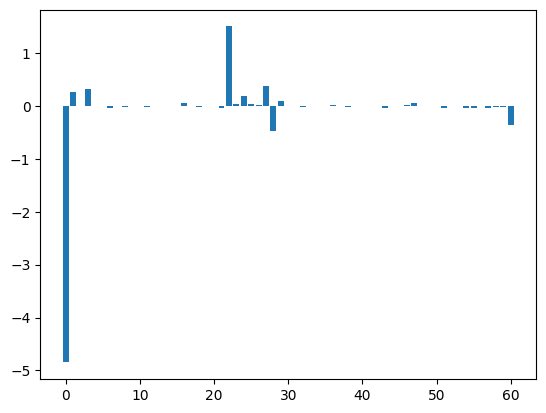

In [25]:
plt.bar(
    np.arange(gbm_explanation_train.values.shape[1]),
    gbm_explanation_train.values[0]
)

In [26]:
model.bag_gbm.predict(embeddings_to_explain), mil_data_train.y[ids]

(array([11.57625604]), array([11.71487814]))

In [27]:
model.embedder.stnn.estimators_[0].apply(mil_data_train[ids].X)

array([ 60,   7,   8, 100,   7,  80,  95,  67])

In [28]:
np.searchsorted(model.embedder.all_leaves, [7, 8, 110])

array([ 0,  1, 55])

Originally, leaves are numbered not starting from 0, but we can convert the indices:

In [29]:
active_leaves = np.searchsorted(
    model.embedder.all_leaves,
    model.embedder.stnn.estimators_[0].apply(mil_data_train[ids].X)
)
active_leaves

array([27,  0,  1, 48,  0, 38, 47, 31])

We have used normalization of instance counts in embedding:

In [30]:
model.embedder.normalize

True

Therefore, we have to divide the impact of $i$-th leaf among all instance, that fell into it:

In [31]:
instance_level_shap_values = gbm_explanation_train.values[0, active_leaves]
unique_active_leaves, unique_active_counts = np.unique(active_leaves, return_counts=True)
repeat_counts = unique_active_counts[np.searchsorted(unique_active_leaves, active_leaves)]
instance_level_shap_values /= repeat_counts
instance_level_shap_values

array([ 3.81771010e-01, -2.42556487e+00,  2.61948468e-01,  1.35330261e-04,
       -2.42556487e+00, -1.35743274e-02,  6.60409247e-02,  5.23915116e-03])

Bias correction (because not all SHAP values of bag-level model were used):

In [32]:
gbm_explanation_train.values.sum() - instance_level_shap_values.sum()

np.float64(1.1707299507164204)

<BarContainer object of 8 artists>

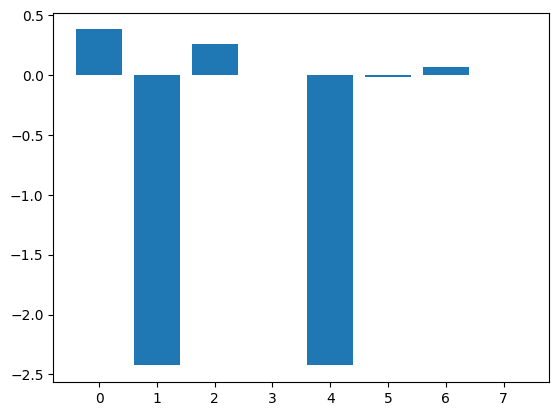

In [33]:
plt.bar(np.arange(instance_level_shap_values.shape[-1]), instance_level_shap_values)

*For simplicity we've implemented it for one instance*

Lets compare the interpretation results with the original model (which is not set-input).

It can be seen, that our instance contributions correlate well with the feature contributions on the
original dataset.
The minor differences are caused by different models used, but the signs, ordering and zero
contributions of the features $5, 6, 7$ are similar.

<BarContainer object of 8 artists>

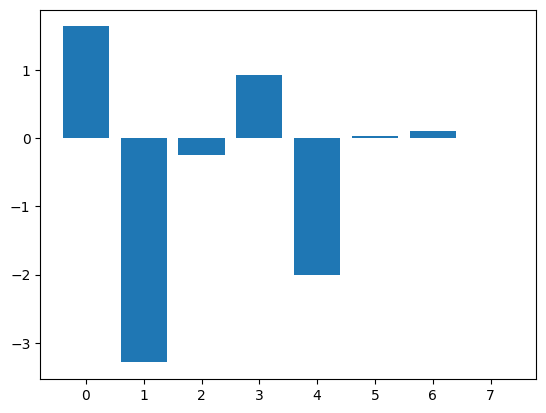

In [34]:
classical_shap_values = shap.TreeExplainer(classical_model)(orig_X[train_idx][ids]).values[0]
plt.bar(np.arange(classical_shap_values.shape[-1]), classical_shap_values)

### Decision Paths

Another interpretation approach is to **look at the instance-level tree**

In [35]:
def get_decision_paths(tree):
    if tree is None:
        return []
    
    paths = []
    stack = [(0, [])]  # Start with root node index 0 and an empty path
    
    while stack:
        node_id, current_path = stack.pop()
        
        if tree.children_left[node_id] == -1:  # Leaf node
            current_path.append((node_id, -1, -1, False))
            paths.append(current_path)
        else:
            feature = int(tree.feature[node_id])
            threshold = float(tree.threshold[node_id])
            left_child = int(tree.children_left[node_id])
            right_child = int(tree.children_right[node_id])
            
            # Push right child first to process left child first (LIFO)
            stack.append((right_child, current_path + [(node_id, feature, threshold, True)]))
            stack.append((left_child, current_path + [(node_id, feature, threshold, False)]))
    
    return paths

In [36]:
relevant_paths = [
    path
    for path in get_decision_paths(model.embedder.stnn.estimators_[0].tree_)
    # if path[-1][0] in active_leaves
]

In [37]:
relevant_paths_by_leaves = {
    int(np.searchsorted(model.embedder.all_leaves, path[-1][0])): path
    for path in relevant_paths
}

For each active leaf we consider the instance-level tree path:

In [38]:
def summarize_path(path):
    bounds = {
        n[1]: (-np.inf, np.inf)
        for n in path
        if n[1] != -1
    }
    for node in path:
        node_id, feature_id, threshold, direction = node
        if feature_id == -1:
            continue
        cur_min, cur_max = bounds[feature_id]
        if direction:
            bounds[feature_id] = (
                max(cur_min, threshold),
                cur_max
            )
        else:
            bounds[feature_id] = (
                cur_min,
                min(cur_max, threshold)
            )
    return bounds

In [39]:
for leaf, value in zip(active_leaves, instance_level_shap_values):
    print('Leaf', leaf, 'shap value =', value)
    path = relevant_paths_by_leaves[leaf]
    print('    Summary:')
    for feature_id, bounds in summarize_path(path).items():
        print(f'    {bounds[0]:.3f} <= x_{feature_id} < {bounds[1]:.3f}')

Leaf 27 shap value = 0.38177100981856893
    Summary:
    0.556 <= x_0 < inf
    -inf <= x_4 < 0.698
    -inf <= x_7 < 0.619
    -inf <= x_6 < 0.425
    -inf <= x_8 < 0.186
    -inf <= x_3 < 0.360
    -inf <= x_5 < 0.253
Leaf 0 shap value = -2.425564873614405
    Summary:
    -inf <= x_0 < 0.323
    -inf <= x_4 < 0.694
    -inf <= x_7 < 0.352
    -inf <= x_6 < 0.797
    -inf <= x_8 < 0.851
    -inf <= x_3 < 0.642
Leaf 1 shap value = 0.26194846771912833
    Summary:
    -inf <= x_0 < 0.323
    -inf <= x_4 < 0.694
    -inf <= x_7 < 0.352
    -inf <= x_6 < 0.797
    -inf <= x_8 < 0.851
    0.642 <= x_3 < inf
Leaf 48 shap value = 0.00013533026068743132
    Summary:
    0.556 <= x_0 < 0.579
    0.698 <= x_4 < inf
Leaf 0 shap value = -2.425564873614405
    Summary:
    -inf <= x_0 < 0.323
    -inf <= x_4 < 0.694
    -inf <= x_7 < 0.352
    -inf <= x_6 < 0.797
    -inf <= x_8 < 0.851
    -inf <= x_3 < 0.642
Leaf 38 shap value = -0.013574327390005043
    Summary:
    0.681 <= x_0 < 0.905
    -

In the context of the artificially generated problem, any feature other than 0
indicate that the instance corresponds to it.

For example, $0 < a \le x_{i} < \infty$ means that the instance fature $x_1$ is *activated*
and $x_0  < b$ means that $z_{i - 1} < b$.

Lets summarize it automatically for this particular example:

In [40]:
for leaf, value in zip(active_leaves, instance_level_shap_values):
    print('Leaf', leaf, 'shap value =', value)
    path = relevant_paths_by_leaves[leaf]
    print('    Summary:')
    for feature_id, bounds in summarize_path(path).items():
        if feature_id == 0:
            print(f'    {bounds[0]:.3f} <= x_{feature_id} < {bounds[1]:.3f}')
        elif bounds[0] != -np.inf:
            print(f'    Original feature {feature_id - 1} is activated')
        

Leaf 27 shap value = 0.38177100981856893
    Summary:
    0.556 <= x_0 < inf
Leaf 0 shap value = -2.425564873614405
    Summary:
    -inf <= x_0 < 0.323
Leaf 1 shap value = 0.26194846771912833
    Summary:
    -inf <= x_0 < 0.323
    Original feature 2 is activated
Leaf 48 shap value = 0.00013533026068743132
    Summary:
    0.556 <= x_0 < 0.579
    Original feature 3 is activated
Leaf 0 shap value = -2.425564873614405
    Summary:
    -inf <= x_0 < 0.323
Leaf 38 shap value = -0.013574327390005043
    Summary:
    0.681 <= x_0 < 0.905
    Original feature 5 is activated
Leaf 47 shap value = 0.06604092467648319
    Summary:
    0.912 <= x_0 < inf
    Original feature 6 is activated
Leaf 31 shap value = 0.005239151156143789
    Summary:
    0.556 <= x_0 < 0.770
    Original feature 7 is activated


As a reference, lets consider the original features, they fully match the predicates found above:

In [41]:
orig_X[train_idx][ids[0]]

array([0.99465383, 0.17949787, 0.31754682, 0.5682914 , 0.00934857,
       0.90064862, 0.97724143, 0.55689468])